# using-a-pretrained-convnet

In [1]:
import keras
keras.__version__

Using TensorFlow backend.
/home/hongta/anaconda3/envs/rcnn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


'2.0.9'

pre-trained Imagenet model:
  - Xception
  - InceptionV3
  - ResNet50
  - VGG16
  - VGg19
  - MobileNet

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [10]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './dataset/dogs_vs_cats/sample'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [11]:
!ls -l {train_dir}/* | wc -l

5005


In [16]:
!ls -l {validation_dir}/* | wc -l

505


In [23]:
!ls -l {test_dir}/* | wc -l

1000


In [7]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode="binary")
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # note that since generators yield data indefinitely in a loop.
            # we muse `break` after evey image has been seen once.
            break
    
    return features, labels

In [32]:
train_features, train_labels = extract_features(train_dir, 5000)
validation_features, validation_labels = extract_features(validation_dir, 500)
#test_features, test_labels = extract_features(test_dir, 1000)

Found 5000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [33]:
train_features.shape

(5000, 4, 4, 512)

In [34]:
train_features = np.reshape(train_features, (5000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (500, 4 * 4 * 512))

In [55]:
validation_features[0]

array([ 0.04416406,  0.        ,  0.        , ...,  0.        ,
        0.41261017,  0.        ])

In [57]:
from keras import models
from keras import layers
from keras import optimizers

d = models.Sequential()
d.add(layers.Dense(256, activation='relu', input_shape=(8192,)))
d.add(layers.Dropout(0.5))
d.add(layers.Dense(1, activation='sigmoid'))

In [58]:
d.compile(optimizer=optimizers.RMSprop(lr=1e-4),
          loss='binary_crossentropy',
          metrics=['acc'])


In [60]:
history = d.fit(train_features,
                train_labels,
                epochs=30,
                batch_size=20,
                validation_data=(validation_features, validation_labels))

Train on 5000 samples, validate on 500 samples
Epoch 1/30
5000/5000 [==============================] - 2s 316us/step - loss: 0.1992 - acc: 0.9178 - val_loss: 0.2884 - val_acc: 0.8640
Epoch 2/30
5000/5000 [==============================] - 2s 326us/step - loss: 0.1806 - acc: 0.9254 - val_loss: 0.2637 - val_acc: 0.8940
Epoch 3/30
5000/5000 [==============================] - 2s 343us/step - loss: 0.1635 - acc: 0.9352 - val_loss: 0.2661 - val_acc: 0.9040
Epoch 4/30
5000/5000 [==============================] - 2s 342us/step - loss: 0.1509 - acc: 0.9426 - val_loss: 0.2867 - val_acc: 0.8560
Epoch 5/30
5000/5000 [==============================] - 2s 343us/step - loss: 0.1343 - acc: 0.9510 - val_loss: 0.2932 - val_acc: 0.8640
Epoch 6/30
5000/5000 [==============================] - 2s 343us/step - loss: 0.1214 - acc: 0.9534 - val_loss: 0.2891 - val_acc: 0.8740
Epoch 7/30
5000/5000 [==============================] - 2s 342us/step - loss: 0.1142 - acc: 0.9558 - val_loss: 0.3180 - val_acc: 0.8600
E

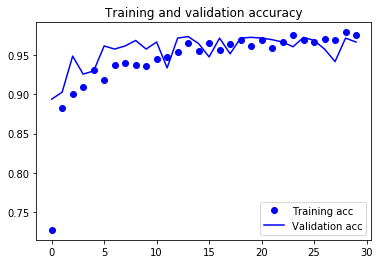

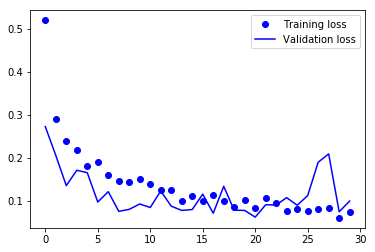

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()
plt.show()

In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [5]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [6]:
conv_base.trainable = False

In [7]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20, 
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')


Found 5000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [13]:
from keras import optimizers

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [17]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 56s 564ms/step - loss: 0.5194 - acc: 0.7270 - val_loss: 0.2722 - val_acc: 0.8940
Epoch 2/30
100/100 [==============================] - 50s 502ms/step - loss: 0.2891 - acc: 0.8825 - val_loss: 0.2052 - val_acc: 0.9030
Epoch 3/30
100/100 [==============================] - 50s 503ms/step - loss: 0.2397 - acc: 0.9010 - val_loss: 0.1349 - val_acc: 0.9490
Epoch 4/30
100/100 [==============================] - 50s 503ms/step - loss: 0.2168 - acc: 0.9090 - val_loss: 0.1706 - val_acc: 0.9260
Epoch 5/30
100/100 [==============================] - 50s 504ms/step - loss: 0.1803 - acc: 0.9315 - val_loss: 0.1650 - val_acc: 0.9300
Epoch 6/30
100/100 [==============================] - 50s 503ms/step - loss: 0.1890 - acc: 0.9185 - val_loss: 0.0968 - val_acc: 0.9620
Epoch 7/30
100/100 [==============================] - 50s 503ms/step - loss: 0.1606 - acc: 0.9380 - val_loss: 0.1209 - val_acc: 0.9580
Epoch 8/30
100/100 [==============================] - 5

In [20]:
model.save('cats_and_dogs_small_3.h5')

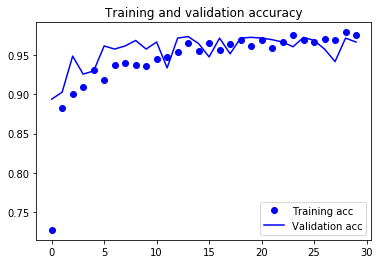

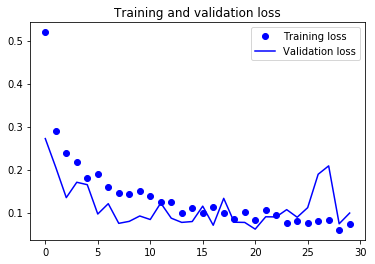

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

The steps for fine-tuning a network are as follow:
  1. Add your custom network on top of an already trained base network
  1. Freeze the base network
  1. Train the part you added.
  1. Unfreeze some layers in the base network.
  1. Joinly train both these layers and the part you added

In [24]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable=True
    
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])



In [28]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 29s 289ms/step - loss: 0.0430 - acc: 0.9840 - val_loss: 0.1004 - val_acc: 0.9760
Epoch 2/30
100/100 [==============================] - 28s 277ms/step - loss: 0.0575 - acc: 0.9780 - val_loss: 0.1180 - val_acc: 0.9690
Epoch 3/30
100/100 [==============================] - 27s 275ms/step - loss: 0.0337 - acc: 0.9885 - val_loss: 0.1462 - val_acc: 0.9670
Epoch 4/30
100/100 [==============================] - 27s 274ms/step - loss: 0.0336 - acc: 0.9840 - val_loss: 0.1320 - val_acc: 0.9730
Epoch 5/30
100/100 [==============================] - 27s 273ms/step - loss: 0.0388 - acc: 0.9855 - val_loss: 0.1675 - val_acc: 0.9670
Epoch 6/30
100/100 [==============================] - 27s 271ms/step - loss: 0.0322 - acc: 0.9880 - val_loss: 0.1412 - val_acc: 0.9720
Epoch 7/30
100/100 [==============================] - 27s 273ms/step - loss: 0.0455 - acc: 0.9840 - val_loss: 0.1202 - val_acc: 0.9700
Epoch 8/30
100/100 [==============================] - 2

In [29]:
model.save('cats_and_dogs_small_4.h5')

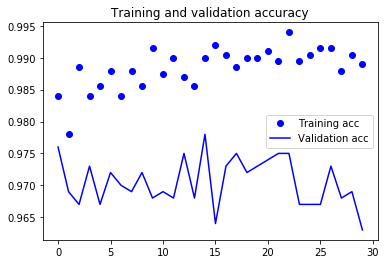

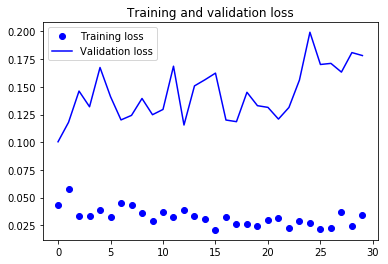

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

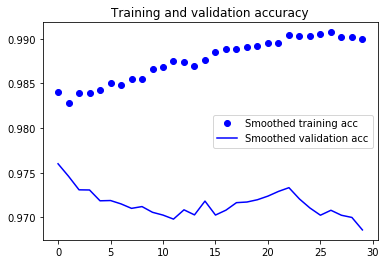

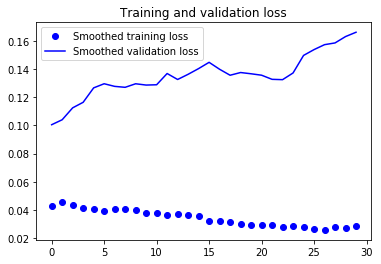

In [32]:
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print("test acc: ", test_acc)